In [ ]:
# default_exp gbe.baseline_drinking.separate

# Factor analysis
Factor analyses require large sample sizes, which this study is perfect for.

> Note: Next step is to get the scoring data per session so tasks is a session-based df. Then this df is averaged before the factor analysis, but session-level scores are used to generate factor scores.

In [ ]:
%matplotlib inline

In [ ]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext rpy2.ipython
import seaborn as sns
from matplotlib import pyplot as plt
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", font_scale = 1.3, rc=custom_params)
from IPython.core.display import HTML

In [ ]:
#export
%load_ext autoreload
%autoreload 2
from trr265.gbe.ist.data_provider import ISTDataProvider
from trr265.gbe.wm.data_provider import WMDataProvider
from trr265.gbe.sst.data_provider import SSTDataProvider
from trr265.gbe.rtt.data_provider import RTTDataProvider

import trr265.gbe.ist.scoring as ist_scoring 
import trr265.gbe.wm.scoring as wm_scoring 
import trr265.gbe.sst.scoring as sst_scoring 
import trr265.gbe.rtt.scoring as rtt_scoring 

import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the data
In this notebook, all tests and examples are run on the initial baseline dataset.

### Information sampling task

In [ ]:
# Getting raw data
dp = ISTDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_ist_data()
# Adding data from redcap
df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
#df = df.query("is_initial and is_baseline")
df = df.query("is_baseline == True")
ist = ist_scoring.get_oversampling_predicted_joint(df)[0]
ist = ist.merge(dp.get_gbe_data(columns = ['participant','session_number']), left_on = 'gbe_index', right_index = True, how = 'left')
#ist = ist.groupby('participant').mean()
ist.columns = ['ist_oversampling','participant','session_number']

R[write to console]: Lade nötiges Paket: lme4

R[write to console]: Lade nötiges Paket: Matrix

R[write to console]: 
Attache Paket: ‘lmerTest’


R[write to console]: Das folgende Objekt ist maskiert ‘package:lme4’:

    lmer


R[write to console]: Das folgende Objekt ist maskiert ‘package:stats’:

    step




### Working memory task

In [ ]:
# Getting raw data
dp = WMDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_wm_data()
# Adding data from redcap
df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
#df = df.query("is_initial and is_baseline")
df = df.query("is_baseline == True")

# Filtering participants with old app
df = dp.filter_old_app_sessions(df)
df = dp.filter_level_two_failures(df)
wm = wm_scoring.get_perc_correct_predicted_sep_trial(df)[0]
wm = wm.merge(dp.get_gbe_data(columns = ['participant','session_number']), left_on = 'gbe_index', right_index = True, how = 'left')
#wm = wm.groupby('participant').mean()
wm = wm.rename(columns={'perc_predicted_sep_trial_no_distractor_1': 'wm_no_1',
                       'perc_predicted_sep_trial_no_distractor_2': 'wm_no_2',
                       'perc_predicted_sep_trial_encoding_distractor': 'wm_encoding',
                       'perc_predicted_sep_trial_delayed_distractor':'wm_delayed'})

8 participants used an old version of the task in some of their sessions.  13 sessions (1.56%) were removed from the dataset.
10 sessions (1.22%) were removed because participants failed a level two trial.


### Risk taking task

In [ ]:
# Getting raw data
dp = RTTDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_rtt_data()
# Adding data from redcap
df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
#df = df.query("is_initial and is_baseline")
df = df.query("is_baseline == True")

rtt = rtt_scoring.get_perc_gamble_predicted_joint(df)[0]
rtt = rtt.merge(dp.get_gbe_data(columns = ['participant','session_number']), left_on = 'gbe_index', right_index = True, how = 'left')
#rtt = rtt.groupby('participant').mean()
rtt = rtt.rename(columns={'perc_gamble_joint_win': 'rtt_win',
                       'perc_gamble_joint_loss': 'rtt_loss',
                       'perc_gamble_joint_mixed': 'rtt_mixed'})

### Stop signal task

In [ ]:
# Getting raw data
dp = SSTDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_sst_data()
# Adding data from redcap
df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
#df = df.query("is_initial and is_baseline")
df = df.query("is_baseline == True")

sst = sst_scoring.get_ssrt_predicted_joint(df)[0]
sst = sst.merge(dp.get_gbe_data(columns = ['participant','session_number']), left_on = 'gbe_index', right_index = True, how = 'left')
#sst = sst.groupby('participant').mean()
sst.columns = ['ssrt','participant','session_number']
sst['ssrt'] = -sst.ssrt # We reverse the SSRTs to align them with other cognitive control measures

## Factor analysis
Using oblimin rotation similar to Eisenberg.

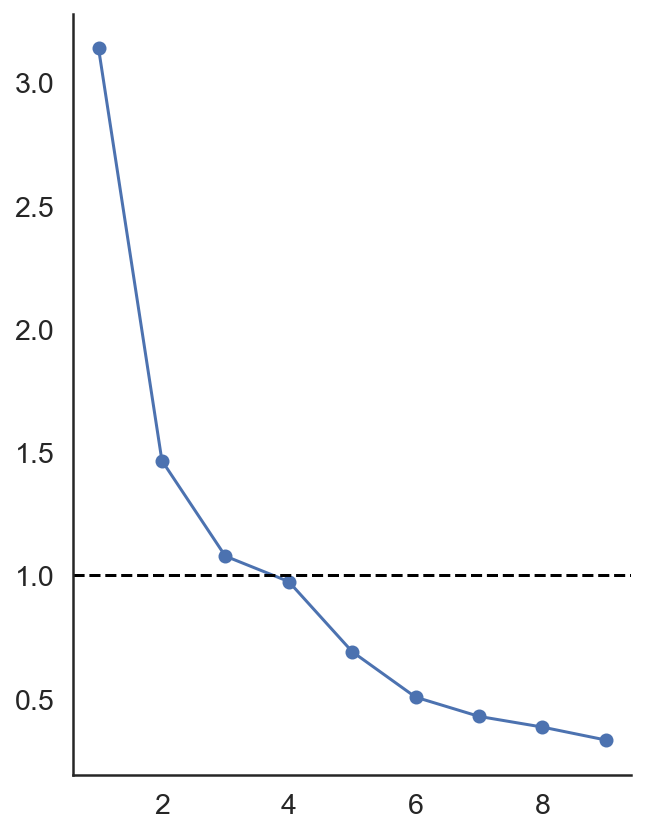

0.8276283147095748


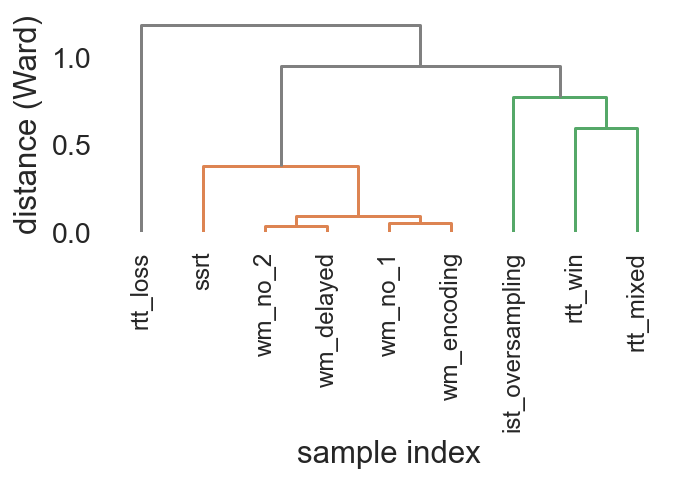

<AxesSubplot:>

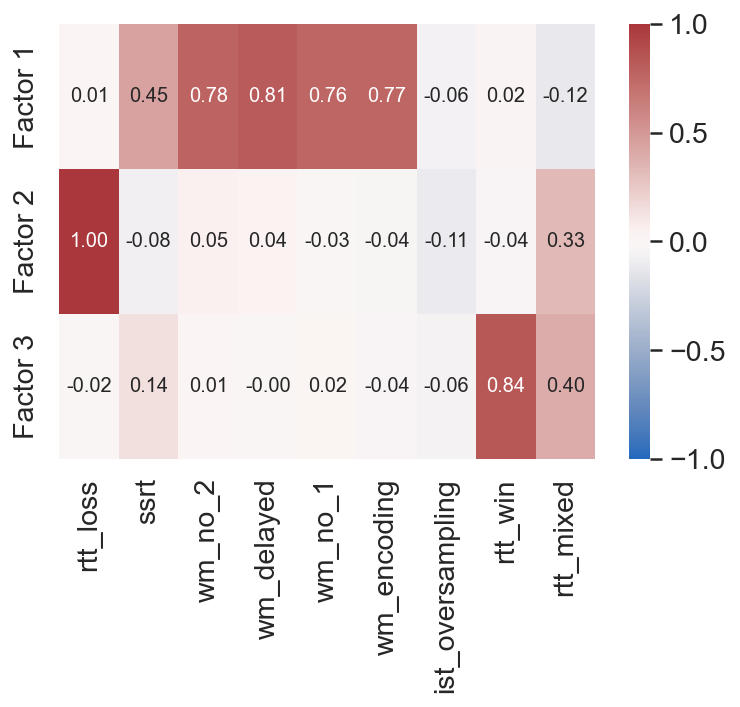

In [ ]:
from factor_analyzer.factor_analyzer import calculate_kmo # The factor_analyzer package is based on the R psych package
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer import FactorAnalyzer

from scipy.spatial.distance import pdist
import numpy as np
from scipy.cluster.hierarchy import linkage
import pandas as pd
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

def check_factor_analysis(df):
    # Testing suitability for factor analysis
    chi_square_value,p_value=calculate_bartlett_sphericity(df)
    kmo_all,kmo_model=calculate_kmo(df)
    bartletts_passed = "passes" if p_value < .05 else "failed"
    display(HTML("Bartlett's test %s: chi_square = %.2f; p = %.2e; Kaiser-Meyer-Olkin test: %.3f (ideally should be above .8)."%(bartletts_passed, chi_square_value, p_value,kmo_model)))
    
    
def scree_plot(df, rotation = 'oblimin'):
    fa = FactorAnalyzer(rotation=rotation)
    fa.fit(df)
    ev, v = fa.get_eigenvalues()
    fig, axes = plt.subplots(1, 1, figsize=(5, 7))
    plt.scatter(range(1, df.shape[1]+1),ev)
    ax = plt.plot(range(1, df.shape[1]+1),ev)
    plt.axhline(1, color = 'black', linestyle = '--')
    plt.show()
    
def factor_analysis(df, n_factors, rotation = 'oblimin'):
    fa = FactorAnalyzer(rotation=rotation, n_factors = n_factors)
    fa.fit(df)
    return fa

def get_factor_loadings(fa, df):
     return pd.DataFrame(fa.loadings_, columns = ["Factor %d"%i for i in range(1, fa.n_factors+1)], index = df.columns)
    
def dendogram(df, distances = 'euclidean'):
    #d = np.transpose(np.arange(1,10001).reshape(100,100))
    d = df.values
    distances = pdist(d, distances) #euclidean
    link = linkage(distances, "average")
    default_color_threshold = 0.7*np.max(link[:,2])
    print(default_color_threshold)
    fig, axes = plt.subplots(1, 1, figsize=(5, 2))
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    plt.xlabel('sample index')
    plt.ylabel('distance (Ward)')
    dendo = dendrogram(link, labels=df.index, leaf_rotation=90,color_threshold=default_color_threshold, above_threshold_color= 'grey')
    plt.show()
    return dendo
    
def factor_loading_heatmap(factor_loadings,column_order):
    return sns.heatmap(factor_loadings.T[column_order], annot=True, center = 0, vmin=-1, vmax=1, cmap = sns.color_palette("vlag", as_cmap=True), fmt=".2f", annot_kws={'size': 10})


# Calculating factors based on average session scores   
tasks = pd.concat([wm.groupby('participant').mean(), 
                   sst.groupby('participant').mean(), # Note that we reversed the SST data
                   rtt.groupby('participant').mean(),
                   ist.groupby('participant').mean()],axis = 1).dropna().drop(columns='session_number')

check_factor_analysis(tasks)
scree_plot(tasks, rotation = 'oblimin')
fa = factor_analysis(tasks, 3, rotation = 'oblimin')
factor_loadings = get_factor_loadings(fa, tasks)
dendo = dendogram(factor_loadings)
factor_loading_heatmap(factor_loadings, dendo['ivl'])


### Factor scores
Factor scores calculated via the ten Berge method (for oblim rotation; Eisenberg; https://www.sciencedirect.com/science/article/pii/S0024379597100076; https://stackoverflow.com/questions/67856186/correct-way-to-calculate-correlations-between-factors).

In [ ]:
import warnings
import numpy as np
from sklearn.preprocessing import scale

def matrix_sqrt(x):
    """
    Compute the square root of the eigen values (eVal),
    and then take $eVec * diag(eVals^0.5) * eVec^T$
    """
    evals, evecs = np.linalg.eig(x)
    evals[evals < 0] = np.finfo(float).eps
    sqrt_evals = np.sqrt(evals)
    return evecs.dot(np.diag(sqrt_evals)).dot(evecs.T)


def inv_matrix_sqrt(x):
    """
    Compute the inverse square root of the eigen values (eVal),
    and then take $eVec * diag(1 / eVals^0.5) * eVec^T$
    """
    evals, evecs = np.linalg.eig(x)
    if np.iscomplex(evals).any():
        warnings.warn('Complex eigen values detected; results are suspect.')
        return x
    evals[evals < np.finfo(float).eps] = 100 * np.finfo(float).eps
    inv_sqrt_evals =  1 / np.sqrt(evals)
    return evecs.dot(np.diag(inv_sqrt_evals)).dot(evecs.T)


def ten_berge(X, loadings, phi=None):
    """
    Estimate factor scores using the "ten Berge" method.

    Parameters
    ----------
    X : array-like
        The data set
    loadings : array-like
        The loadings matrix

    Reference
    ----------
    https://www.sciencedirect.com/science/article/pii/S0024379597100076
    """
    # get the number of factors from the loadings
    n_factors = loadings.shape[1]
    corr = np.corrcoef(X, rowvar=False)
    # if `phi` is None, create a diagonal matrix
    phi = np.diag(np.ones(n_factors)) if phi is None else phi
    # calculate intermediate metrics
    load = loadings.dot(matrix_sqrt(phi))
    corr_inv = inv_matrix_sqrt(corr)
    temp = corr_inv.dot(load)\
                   .dot(inv_matrix_sqrt(load.T.dot(np.linalg.inv(corr))
                                              .dot(load)))
    # calcualte weights
    weights = corr_inv.dot(temp)\
                      .dot(matrix_sqrt(phi))
    # calculate scores, given weights
    scores = scale(X).dot(weights)
    return scores




df = pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/psych/bfi.csv')
df = df.filter(regex='^A[1-5]|^N').copy()
df = df.fillna(df.median(0))

fa2 = FactorAnalyzer(n_factors=5, rotation=None).fit(df)
pd.DataFrame(ten_berge(df, fa2.loadings_))#.corr().round(3)

,0,1,2,3,4
0,0.121884,-1.002152,0.474970,-0.475818,-1.053176
1,0.427809,-0.299478,-1.679099,-0.975914,1.389933
2,0.681850,-0.301633,1.736997,-0.574156,0.858989
3,-0.146482,0.033403,1.053652,-0.551671,0.967112
4,0.312234,-0.935472,-0.776004,0.628900,0.746936
...,...,...,...,...,...
2795,-0.259025,-3.285772,0.604933,0.964400,1.967736
2796,-0.066261,-0.771753,-0.310352,-0.923695,0.334712
2797,0.194572,-0.825589,0.016709,-1.967229,1.064684
2798,1.816658,-1.339774,1.546495,0.782132,1.152447


In [ ]:
tasks_session = pd.concat([wm, sst,rtt, ist],axis = 1).dropna()
tasks_session = tasks_session.loc[:,~tasks_session.columns.duplicated()]
tasks_session = tasks_session.set_index(['participant','session_number'])

In [ ]:
tasks_session

wm_no_2   wm_no_1  wm_encoding  wm_delayed  \
participant session_number                                                
b001        1.0             0.982995  0.968828     0.848913    0.828462   
            2.0             0.982995  0.906931     0.967626    0.869585   
b002        1.0             0.978210  0.979587     0.978041    0.966600   
b012        1.0             0.742192  0.857477     0.982403    0.958512   
            2.0             0.959463  0.963901     0.982403    0.897683   
...                              ...       ...          ...         ...   
m276        1.0             0.764320  0.712817     0.644319    0.521598   
            2.0             0.713710  0.712817     0.483920    0.422925   
m279        1.0             0.982995  0.968828     0.982403    0.725788   
            2.0             0.982995  0.906931     0.982403    0.858376   
m280        1.0             0.978210  0.979587     0.978041    0.966600   

                                  ssrt   rtt_win  rtt_loss  rtt_mixed  \
participant session_number                                              
b001        1.0            -333.628958  0.592239  0.301194   0.315459   
            2.0            -336.117870  0.767259  0.355462   0.602074   
b002        1.0            -380.851519  0.945104  0.679461   0.871982   
b012        1.0            -412.172670  0.665761  0.727967   0.908571   
            2.0            -324.418454  0.779319  0.825303   0.908571   
...                                ...       ...       ...        ...   
m276        1.0            -370.367611  0.156942  0.256125   0.354740   
            2.0            -370.382191  0.261880  0.161096   0.248872   
m279        1.0            -362.404648  0.650759  0.112362   0.487310   
            2.0            -339.692973  0.709446  0.079098   0.429114   
m280        1.0            -410.762788  0.719608  0.603263   0.611823   

                            ist_oversampling  
participant session_number                    
b001        1.0                     0.014824  
            2.0                     0.014824  
b002        1.0                    -0.010813  
b012        1.0                    -0.806433  
            2.0                    -0.740676  
...                                      ...  
m276        1.0                    -0.614798  
            2.0                    -0.581920  
m279        1.0                    -0.757115  
            2.0                    -0.789994  
m280        1.0                     0.805437  

[797 rows x 9 columns]

In [ ]:
factor_scores

,Factor 1,Factor 2,Factor 3
0,0.537029,-0.527881,-0.140489
1,0.631110,-0.296515,0.601452
2,0.927345,1.085834,1.288571
3,0.130961,1.236273,0.338398
4,0.857733,1.689015,0.817341
...,...,...,...
792,-1.551331,-0.799778,-1.436524
793,-2.189673,-1.212865,-1.069366
794,0.463881,-1.357425,0.136267
795,0.613545,-1.481311,0.294501


In [ ]:
factor_scores = pd.DataFrame(ten_berge(tasks_session, fa.loadings_))
factor_scores.columns = ['Factor 1','Factor 2','Factor 3']
factor_scores = pd.concat([tasks_session.reset_index(),factor_scores],axis = 1)

In [ ]:
factor_scores.set_index(['participant','session_number']).corr()

,wm_no_2,wm_no_1,wm_encoding,wm_delayed,ssrt,rtt_win,rtt_loss,rtt_mixed,ist_oversampling,Factor 1,Factor 2,Factor 3
wm_no_2,1.000000,0.491408,0.472989,0.537762,0.323270,0.085684,-0.018813,-0.029434,-0.049776,7.892982e-01,1.559170e-02,5.155835e-02
wm_no_1,0.491408,1.000000,0.499343,0.530246,0.295827,0.113005,-0.091574,-0.080290,-0.058201,7.772796e-01,-6.303543e-02,5.999841e-02
wm_encoding,0.472989,0.499343,1.000000,0.531641,0.338442,0.086260,-0.089925,-0.114881,-0.041865,7.753689e-01,-7.517568e-02,-7.447095e-04
wm_delayed,0.537762,0.530246,0.531641,1.000000,0.357525,0.096294,-0.039164,-0.028243,-0.030158,8.230022e-01,-8.088582e-04,4.387140e-02
ssrt,0.323270,0.295827,0.338442,0.357525,1.000000,0.170989,-0.124069,-0.020150,-0.081653,4.649169e-01,-1.002674e-01,1.862364e-01
rtt_win,0.085684,0.113005,0.086260,0.096294,0.170989,1.000000,-0.029362,0.314982,-0.077543,7.204614e-02,-2.624636e-02,9.826281e-01
rtt_loss,-0.018813,-0.091574,-0.089925,-0.039164,-0.124069,-0.029362,1.000000,0.331955,-0.115396,-3.686471e-02,9.988380e-01,-4.466612e-03
rtt_mixed,-0.029434,-0.080290,-0.114881,-0.028243,-0.020150,0.314982,0.331955,1.000000,-0.032403,-1.189325e-01,3.436361e-01,4.624635e-01
ist_oversampling,-0.049776,-0.058201,-0.041865,-0.030158,-0.081653,-0.077543,-0.115396,-0.032403,1.000000,-6.277860e-02,-1.083864e-01,-7.107466e-02
Factor 1,0.789298,0.777280,0.775369,0.823002,0.464917,0.072046,-0.036865,-0.118933,-0.062779,1.000000e+00,1.480483e-15,5.163860e-16


R[write to console]: Lade nötiges Paket: psych



,type,ICC,F,df1,df2,p,lower bound,upper bound,description
Single_raters_absolute,ICC1,0.798,8.913,361.0,362.0,0.0,0.765,0.828,".80 (.76, .83)"
Single_random_raters,ICC2,0.799,9.210,361.0,361.0,0.0,0.763,0.830,".80 (.76, .83)"
Single_fixed_raters,ICC3,0.804,9.210,361.0,361.0,0.0,0.771,0.833,".80 (.77, .83)"
Average_raters_absolute,ICC1k,0.888,8.913,361.0,362.0,0.0,0.867,0.906,".89 (.87, .91)"
Average_random_raters,ICC2k,0.888,9.210,361.0,361.0,0.0,0.865,0.907,".89 (.87, .91)"
Average_fixed_raters,ICC3k,0.891,9.210,361.0,361.0,0.0,0.871,0.909,".89 (.87, .91)"


,variance,Percent
ID,0.782,0.799
Items,0.006,0.006
Residual,0.191,0.195
Total,0.979,1.000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


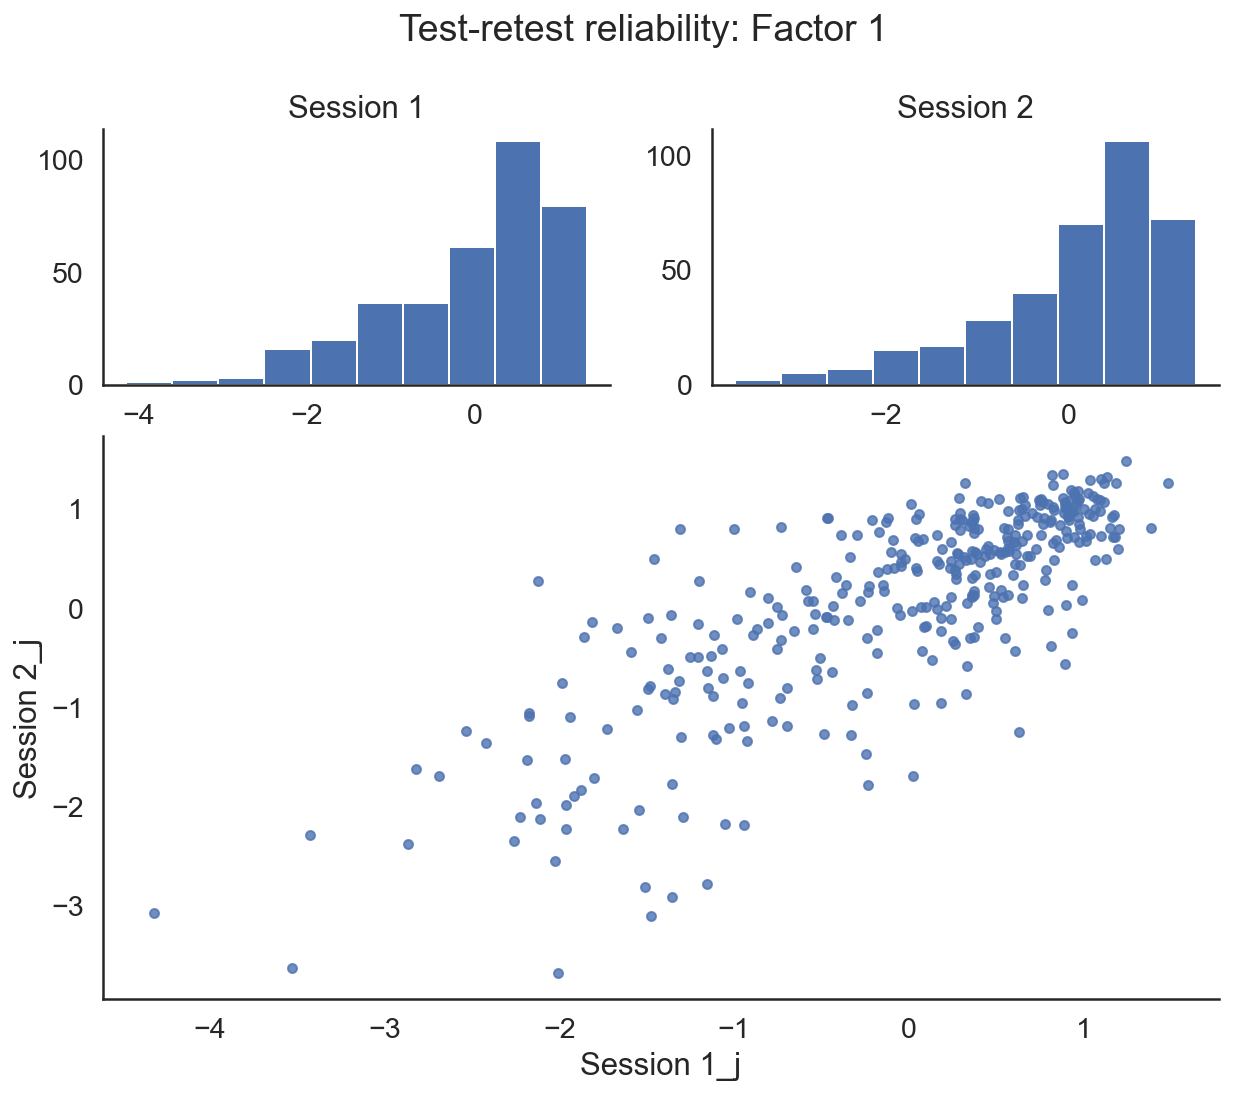

In [ ]:
import trr265.stats as stats

iccs_mean = stats.analyze_reliability(factor_scores, dependent = 'Factor 1', add_jitter = True)

,type,ICC,F,df1,df2,p,lower bound,upper bound,description
Single_raters_absolute,ICC1,0.767,7.598,361.0,362.0,0.0,0.729,0.801,".77 (.73, .80)"
Single_random_raters,ICC2,0.770,8.331,361.0,361.0,0.0,0.712,0.814,".77 (.71, .81)"
Single_fixed_raters,ICC3,0.786,8.331,361.0,361.0,0.0,0.750,0.817,".79 (.75, .82)"
Average_raters_absolute,ICC1k,0.868,7.598,361.0,362.0,0.0,0.843,0.889,".87 (.84, .89)"
Average_random_raters,ICC2k,0.870,8.331,361.0,361.0,0.0,0.832,0.897,".87 (.83, .90)"
Average_fixed_raters,ICC3k,0.880,8.331,361.0,361.0,0.0,0.857,0.899,".88 (.86, .90)"


,variance,Percent
ID,0.791,0.77
Items,0.021,0.02
Residual,0.216,0.21
Total,1.027,1.00


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


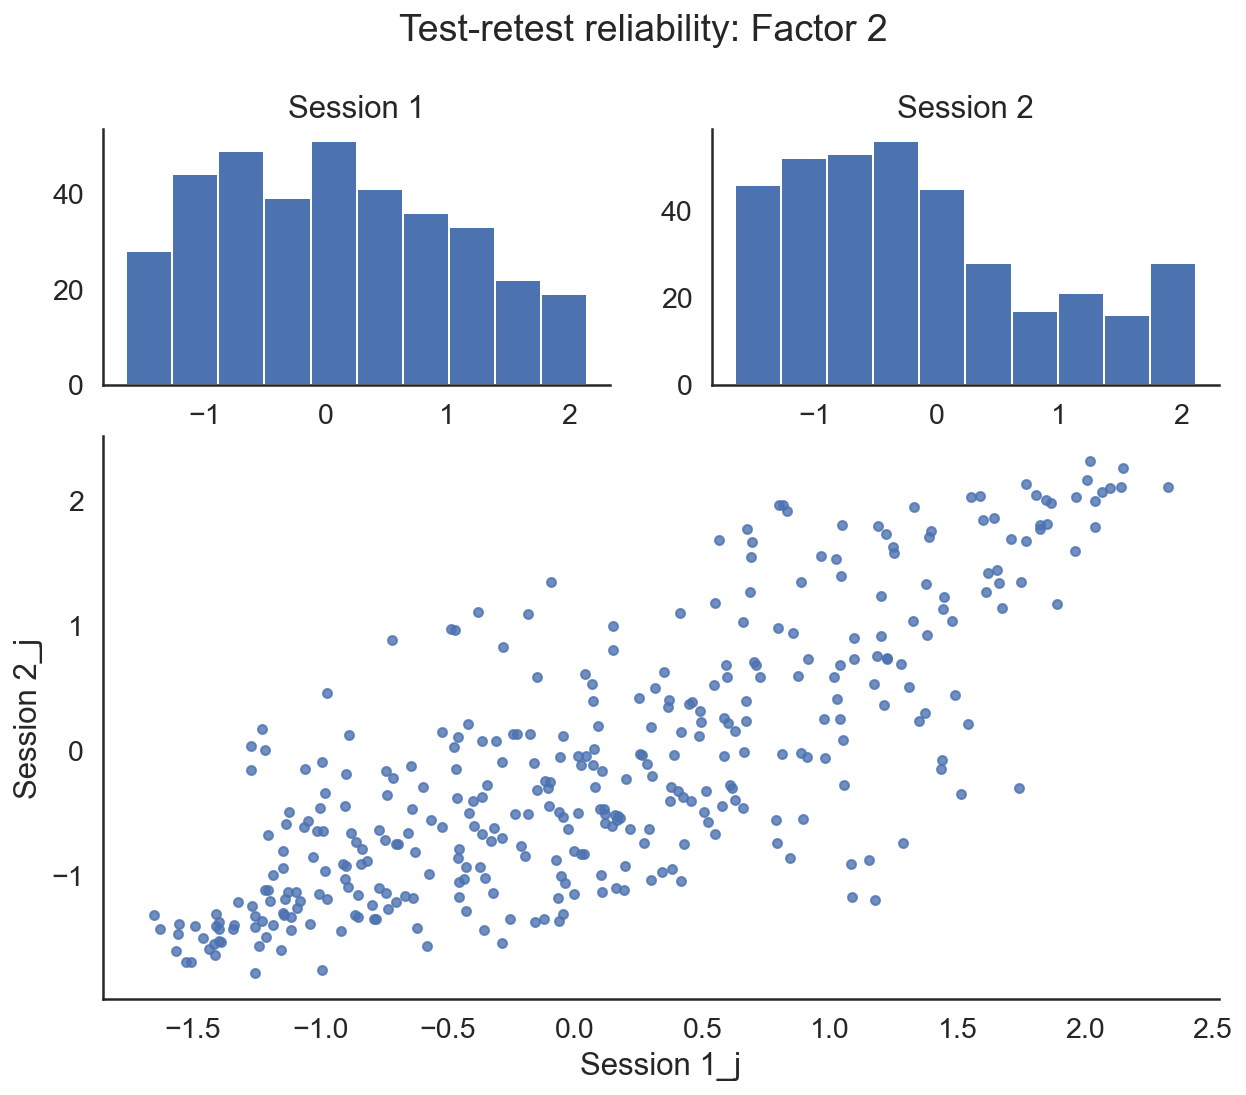

In [ ]:
iccs_mean = stats.analyze_reliability(factor_scores, dependent = 'Factor 2', add_jitter = True)

,type,ICC,F,df1,df2,p,lower bound,upper bound,description
Single_raters_absolute,ICC1,0.768,7.605,361.0,362.0,0.0,0.730,0.801,".77 (.73, .80)"
Single_random_raters,ICC2,0.770,8.383,361.0,361.0,0.0,0.711,0.815,".77 (.71, .82)"
Single_fixed_raters,ICC3,0.787,8.383,361.0,361.0,0.0,0.752,0.818,".79 (.75, .82)"
Average_raters_absolute,ICC1k,0.869,7.605,361.0,362.0,0.0,0.844,0.889,".87 (.84, .89)"
Average_random_raters,ICC2k,0.870,8.383,361.0,361.0,0.0,0.831,0.898,".87 (.83, .90)"
Average_fixed_raters,ICC3k,0.881,8.383,361.0,361.0,0.0,0.858,0.900,".88 (.86, .90)"


,variance,Percent
ID,0.045,0.770
Items,0.001,0.021
Residual,0.012,0.209
Total,0.058,1.000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


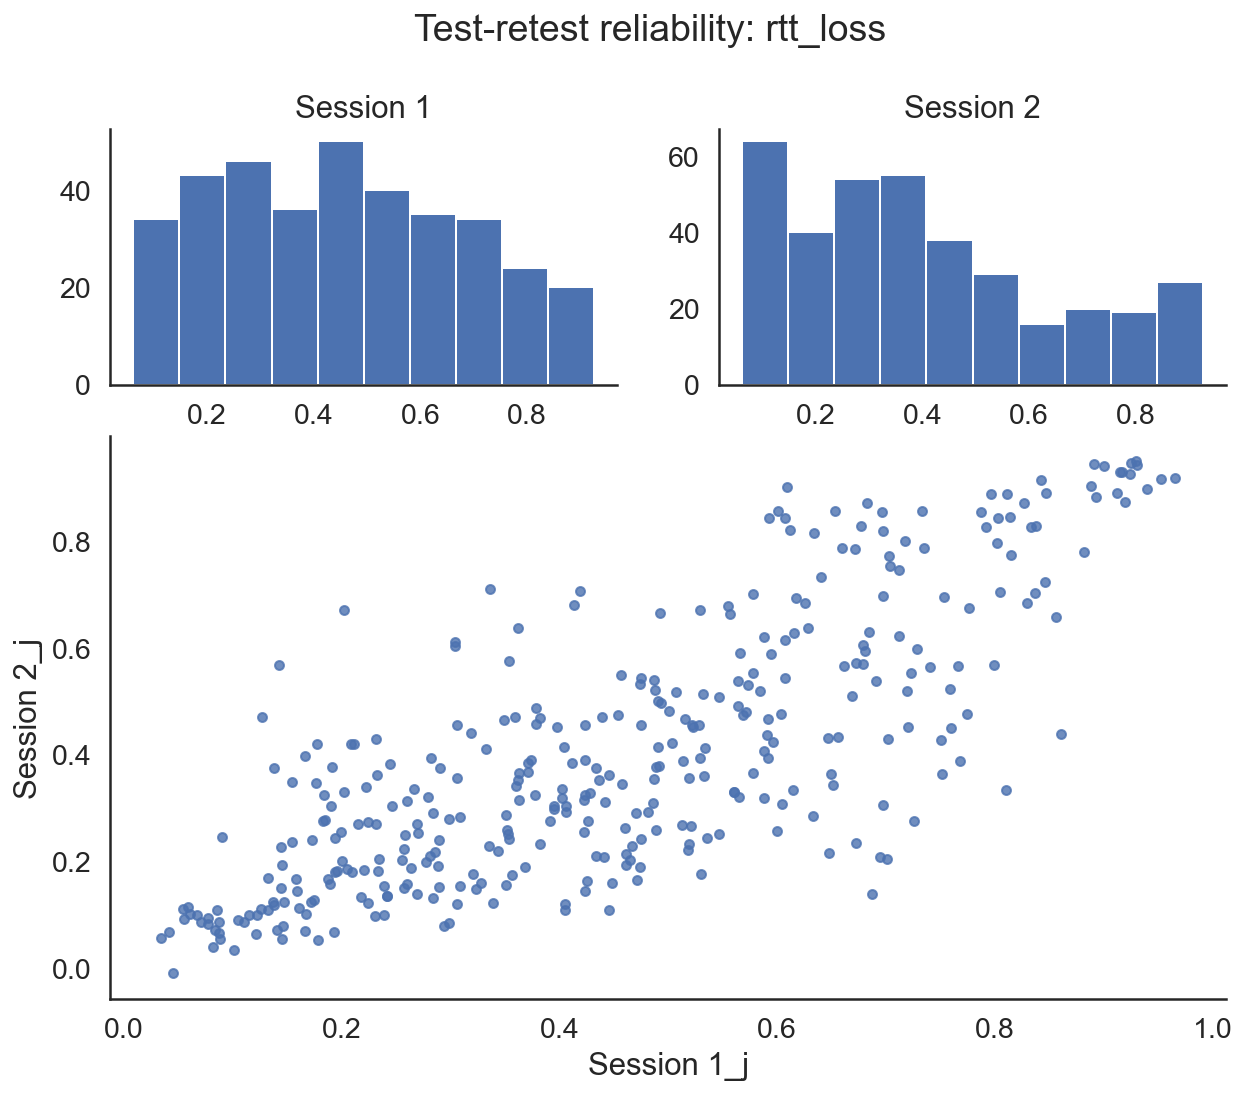

In [ ]:
iccs_mean = stats.analyze_reliability(factor_scores, dependent = 'rtt_loss', add_jitter = True)

,type,ICC,F,df1,df2,p,lower bound,upper bound,description
Single_raters_absolute,ICC1,0.814,9.771,361.0,362.0,0.0,0.783,0.842,".81 (.78, .84)"
Single_random_raters,ICC2,0.815,9.912,361.0,361.0,0.0,0.783,0.842,".81 (.78, .84)"
Single_fixed_raters,ICC3,0.817,9.912,361.0,361.0,0.0,0.786,0.844,".82 (.79, .84)"
Average_raters_absolute,ICC1k,0.898,9.771,361.0,362.0,0.0,0.878,0.914,".90 (.88, .91)"
Average_random_raters,ICC2k,0.898,9.912,361.0,361.0,0.0,0.878,0.914,".90 (.88, .91)"
Average_fixed_raters,ICC3k,0.899,9.912,361.0,361.0,0.0,0.880,0.915,".90 (.88, .92)"


,variance,Percent
ID,0.827,0.815
Items,0.003,0.003
Residual,0.186,0.183
Total,1.015,1.000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


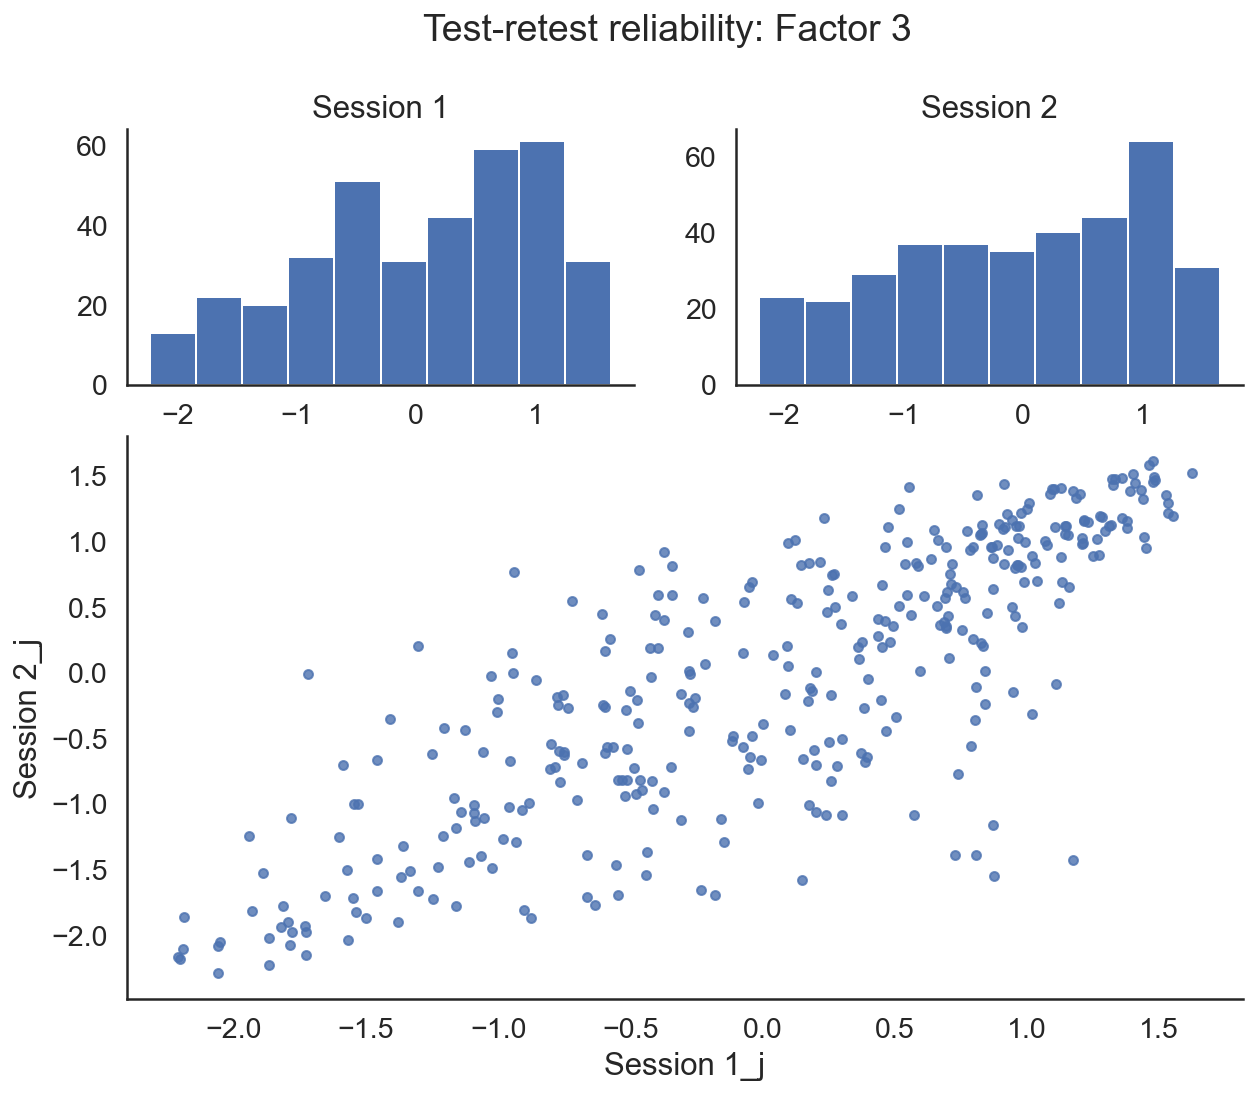

In [ ]:
iccs_mean = stats.analyze_reliability(factor_scores, dependent = 'Factor 3', add_jitter = True)